# Preamble

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
#from scipy.interpolate import interp1d
#from scipy.integrate import trapz
#from scipy.integrate import quad
from scipy.optimize import fsolve

from utils.my_units import *
from superrad import ultralight_boson as ub

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Useful functions

In [4]:
### Approximate value of the min and max alpha (here Delta a_star is taken to be = a_star, which is okay for small alpha)

def alpha_min_fn(mu, a_star, f_dot_obs):
    return (4*np.pi/75* f_dot_obs / (mu**2*a_star**2))**(1/13) 

def alpha_max_fn(mu, a_star, tau_cut):
    return 1/(tau_cut*60*mu*a_star)**(1/10)

In [5]:
def EM_lum_fit(alpha):
    return (0.131*alpha-0.188*alpha**2)

def EM_lum(eps, alpha, Mc, MBH):
    return eps**2*(0.131*alpha-0.188*alpha**2)*Mc/(GN*MBH)

def EM_lum_approx(eps, alpha, a_star):
    return eps**2*(0.13*alpha-0.188*alpha**2)*delta_as_fn(a_star, alpha)*alpha*(1-alpha**2/2)/(GN)

In [6]:
### Electric field
def Efield_fn(epsilon, alpha, mu, Nocc):
    return 1/np.sqrt(np.pi)*epsilon*alpha**(3/2)*mu**2*np.sqrt(Nocc)

### Pair production rate
def Gamma_pair_fn(epsilon, mu, alpha, Nocc):
    
    E_field = Efield_fn(epsilon, alpha, mu, Nocc)
    exp_factor = 4*MElectron**6*mu**2/((ElectronCharge*E_field)**4)
    
    return AlphaEM/(2*np.pi)*ElectronCharge*E_field/MElectron*np.exp(-exp_factor)

def tplasma_fn(epsilon, mu, alpha, Nocc):
    
    ne = alpha*mu*Efield_fn(epsilon, alpha, mu, Nocc)/ElectronCharge   
    
    if Gamma_pair_fn(epsilon, mu, alpha, Nocc) > 0:
        return 1/(2*Gamma_pair_fn(epsilon, mu, alpha, Nocc))*np.log(ne/(alpha*mu)**3)
    else:
        return np.nan

# Fake pulsars

In [7]:
df_pulsar_all = pd.read_csv('data/all_pulsars.csv', index_col=0)
df_pulsar_all = df_pulsar_all.iloc[: , :-1]
df_pulsar_all.columns

print(len(df_pulsar_all))
print(len(df_pulsar_all))
df_pulsar_all = df_pulsar_all[(~df_pulsar_all['F0'].isna())] ### Remove pulsars with no F0 measurement
len(df_pulsar_all)

3342
3342


3308

## Find frequency multiples

In [8]:
start_f = 50 # minimum frequency
#df_pulsar_all_sub = df_pulsar_all[((df_pulsar_all['F0'].to_numpy() > start_f) & (df_pulsar_all['BINARY'].isna()) & ((df_pulsar_all['F1'].isna()) | (df_pulsar_all['F1'].to_numpy() > 0)))]
df_pulsar_all_sub = df_pulsar_all[((df_pulsar_all['F0'].to_numpy() > start_f) & ((df_pulsar_all['F1'].isna()) | (df_pulsar_all['F1'].to_numpy() > 0)) & (~df_pulsar_all['DIST'].isna()))]
df_pulsar_all_sub.sort_values(by='F0', inplace=True)
len(df_pulsar_all_sub)

<ipython-input-8-eb5d95afb7ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pulsar_all_sub.sort_values(by='F0', inplace=True)


229

In [9]:
min(df_pulsar_all_sub['F0'].to_numpy()), max(df_pulsar_all_sub['F0'].to_numpy())

(53.69521999999999, 669.933583)

In [10]:
### Find frequency triplets 

freq_list = df_pulsar_all_sub['F0'].to_numpy()
triplet_ind_list = []

for i, f in tqdm(enumerate(freq_list)):
    
    pairs_ind = np.where(np.abs(f - freq_list)/f < 0.001)[0]

    if len(pairs_ind)>2:
        triplet_ind_list.append(pairs_ind.tolist())
        print(len(pairs_ind)-1, ' pairs found for f = ', f, '  i = ', i)

### Remove double counting
triplet_ind_list = list(set( tuple(x) for x in triplet_ind_list))
triplet_ind_list = np.array(list(set( tuple(x) for x in triplet_ind_list)))
print(len(triplet_ind_list))    

229it [00:00, 68562.75it/s]

2  pairs found for f =  227.42779199999998   i =  113
2  pairs found for f =  311.493418   i =  160
2  pairs found for f =  311.52648   i =  161
2  pairs found for f =  311.52648   i =  162
2  pairs found for f =  337.837838   i =  177
2  pairs found for f =  337.837838   i =  178
2  pairs found for f =  337.974855   i =  179
3


In [11]:
### Find frequency doublets 

freq_list = df_pulsar_all_sub['F0'].to_numpy()
pairs_ind_list = []

for i, f in tqdm(enumerate(freq_list)):
    
    pairs_ind = np.where(np.abs(f - freq_list)/f < 0.001)[0]

    if ((len(pairs_ind)>1) & (len(pairs_ind)<=2)) :
        pairs_ind_list.append(pairs_ind.tolist())
        print(len(pairs_ind)-1, ' pairs found for f = ', f, '  i = ', i)

### Remove double counting
pairs_ind_list = list(set( tuple(x) for x in pairs_ind_list))
pairs_ind_list = np.array(list(set( tuple(x) for x in pairs_ind_list)))
print(len(pairs_ind_list))    

229it [00:00, 16946.83it/s]

1  pairs found for f =  103.263527   i =  18
1  pairs found for f =  103.305785   i =  19
1  pairs found for f =  128.205128   i =  31
1  pairs found for f =  128.205128   i =  32
1  pairs found for f =  131.233596   i =  33
1  pairs found for f =  131.356873   i =  34
1  pairs found for f =  141.043724   i =  38
1  pairs found for f =  141.145053   i =  39
1  pairs found for f =  179.600927   i =  64
1  pairs found for f =  179.700978   i =  65
1  pairs found for f =  184.501845   i =  72
1  pairs found for f =  184.614253   i =  73
1  pairs found for f =  195.3125   i =  79
1  pairs found for f =  195.32356299999998   i =  80
1  pairs found for f =  196.463654   i =  82
1  pairs found for f =  196.58299399999999   i =  83
1  pairs found for f =  207.747779   i =  91
1  pairs found for f =  207.89296299999998   i =  92
1  pairs found for f =  219.565606   i =  105
1  pairs found for f =  219.56788999999998   i =  106
1  pairs found for f =  225.225225   i =  109
1  pairs found for f =

## Range of allowed alpha values

In [12]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [13]:
pair_ind = np.array([pairs_ind_list]).flatten()
triplet_ind = np.array([triplet_ind_list]).flatten()
pair_ind = pair_ind[~np.isin(pair_ind, triplet_ind)]

### Frequency triplets

In [14]:
### Determine the range of alpha allowed for each pulsar

mbh_min, mbh_max = 3*MSolar, 100*MSolar
abh0 = 0.5
alpha_points_sol = 100
t_cutoff = 1e3*Year
alpha_points = 50

mu_list_tr = 2*np.pi*df_pulsar_all_sub.iloc[triplet_ind]['F0'].to_numpy()*Hz

alpha_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points)) #np.nan+np.zeros((len(triplet_ind), alpha_points))

for i in range(len(triplet_ind)):
    
    mu = mu_list_tr[i]
    alpha_cutoff = 1.5*np.power(17*mu*0.1*t_cutoff, -1/10) ## take a factor of 1.5 greater than the estimated max alpha value
    alpha_min = GN*mu*mbh_min
    alpha_max = min(alpha_cutoff, GN*mu*mbh_max)
    
    if alpha_cutoff > GN*mu*mbh_max:
        print('yes ', mu)
    
    if(alpha_max > alpha_min):
        
        alpha_list_temp = np.logspace(np.log10(alpha_min), np.log10(alpha_max), alpha_points_sol)
        gw_time_list_temp = np.nan+np.zeros(alpha_points_sol)
        
        for i_a, alpha in enumerate(alpha_list_temp):

            mbh = alpha/(mu*GN)/MSolar
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                gw_time_list_temp[i_a] = wf.gw_time()*Second
               
        alpha_cutoff = 10**np.interp(0, np.flipud(np.log10(gw_time_list_temp/t_cutoff)), np.flipud(np.log10(alpha_list_temp)), left=np.nan, right=np.nan)
        alpha_list_tr[i] = np.logspace(np.log10(alpha_min), np.log10(alpha_cutoff), alpha_points) #[alpha_min, alpha_cutoff] #

In [15]:
min(alpha_list_tr[:, -1]), max(alpha_list_tr[:, -1])

(0.03430407281532438, 0.035782293766343905)

In [16]:
t_age = 1e3*Year

rel_deltaf_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
strain_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
fdot_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_max_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_lum_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
lum_cutoff = 1e30*erg/Second

for i, p_index in enumerate(triplet_ind):

    mu = mu_list_tr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_tr[i]):

        mbh = alpha_list_tr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_tr[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_tr[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    
            fdot_list_tr[i][i_a] = wf.freqdot_gw(t_age/Second)

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_tr[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_tr[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_tr[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_tr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-16-052cfd5e47a2>:35: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


In [17]:
t_age = 1e6*Year

strain_list_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
rel_deltaf_list_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_max_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_lum_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))

for i, p_index in enumerate(triplet_ind):

    mu = mu_list_tr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_tr[i]):

        mbh = alpha_list_tr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_tr_1[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_tr_1[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_tr_1[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_tr_1[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_tr_1[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_tr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-17-c4f4d730796b>:32: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


In [18]:
### Determine the range of alpha allowed for each pulsar
mbh_min, mbh_max = 3*MSolar, 100*MSolar
abh0 = 0.5
alpha_points_sol = 100
t_cutoff = 1e3*Year
alpha_points = 50

mu_list_pr = 2*np.pi*df_pulsar_all_sub.iloc[pair_ind]['F0'].to_numpy()*Hz

alpha_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points)) #np.nan+np.zeros((len(pair_ind), alpha_points))

for i in range(len(pair_ind)):
    
    mu = mu_list_pr[i]
    alpha_cutoff = 1.5*np.power(17*mu*0.1*t_cutoff, -1/10) ## take a factor of 1.5 greater than the estimated max alpha value
    alpha_min = GN*mu*mbh_min
    alpha_max = min(alpha_cutoff, GN*mu*mbh_max)
    
    if(alpha_max > alpha_min):
        
        alpha_list_temp = np.logspace(np.log10(alpha_min), np.log10(alpha_max), alpha_points_sol)
        gw_time_list_temp = np.nan+np.zeros(alpha_points_sol)
        
        for i_a, alpha in enumerate(alpha_list_temp):

            mbh = alpha/(mu*GN)/MSolar
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                gw_time_list_temp[i_a] = wf.gw_time()*Second
               
        alpha_cutoff = 10**np.interp(0, np.flipud(np.log10(gw_time_list_temp/t_cutoff)), np.flipud(np.log10(alpha_list_temp)), left=np.nan, right=np.nan)
        alpha_list_pr[i] = np.logspace(np.log10(alpha_min), np.log10(alpha_cutoff), alpha_points) #[alpha_min, alpha_cutoff] #

In [19]:
t_age = 1e3*Year

rel_deltaf_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
strain_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
fdot_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_max_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_lum_pr = np.nan+np.zeros((len(pair_ind), alpha_points))

for i, p_index in enumerate(pair_ind):

    mu = mu_list_pr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_pr[i]):

        mbh = alpha_list_pr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_pr[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_pr[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    
            fdot_list_pr[i][i_a] = wf.freqdot_gw(t_age/Second)

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_pr[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_pr[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_pr[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_pr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-19-dbf3325e821e>:34: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


In [20]:
t_age = 1e6*Year

strain_list_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
rel_deltaf_list_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_max_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_lum_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))

for i, p_index in enumerate(pair_ind):

    mu = mu_list_pr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_pr[i]):

        mbh = alpha_list_pr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_pr_1[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_pr_1[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_pr_1[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_pr_1[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_pr_1[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_pr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-20-ab5cabd66b20>:32: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


## Pulsars with positive f_dot

In [21]:
df_pulsar = df_pulsar_all[((df_pulsar_all['F1']>0) & (df_pulsar_all['BINARY'].isna()) & (df_pulsar_all['F0']>50))]
len(df_pulsar)
df_pulsar.sort_values(by=['F0'], inplace=True)
#df_pulsar = pd.read_csv('pulsar_data/pulsar_table.csv', index_col=0, keep_default_na=True)
#df_pulsar.columns

<ipython-input-21-84b8950bc1a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pulsar.sort_values(by=['F0'], inplace=True)


In [22]:
alpha_min_list, alpha_max_list = np.zeros(len(df_pulsar)), np.zeros(len(df_pulsar));
abh0 = 0.5 ### Initial BH spin
tau_cutoff = 1000*Year ## Cutoff for the lifetime of the SR cloud

for i in range(len(df_pulsar)):
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[i][['F0', 'F1', 'DIST']].to_numpy()
    mu = 2*np.pi*f_obs*Hz ## Fix the dark photon mass to the pulsar frequency

    alpha_min_list[i], alpha_max_list[i] = alpha_min_fn(mu, abh0, fdot_obs*Hz/Second), alpha_max_fn(mu, abh0, tau_cutoff)

In [23]:
alpha_points = 50

df_res = pd.DataFrame(columns = ['f_obs', 'fdot_obs', 'dist', 'mu', 'alpha', 'Mbh', 'fdot_ratio', 'tauGW', 'strain', 'powGW', 'EM_lum_eps1', 'eps_min', 'eps_max', 'eps_Rlum14'],
                      index = np.linspace(0, len(df_pulsar)*alpha_points-1, len(df_pulsar)*alpha_points));
res_array = np.zeros(df_res.shape)

In [24]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [25]:
mbh_min, mbh_max = 3*MSolar, 30*MSolar
tau_age_cutoff = 1000*Year
radio_frac = 1e-6

for pul_i in tqdm(range(len(df_pulsar))):
    
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[pul_i][['F0', 'F1', 'DIST']].to_numpy()
    mu = 2*np.pi*f_obs*Hz ## Fix the dark photon mass to the pulsar frequency

    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, :4] = [f_obs, fdot_obs, dist, mu/eV]
    
    alpha_list = np.linspace(1.05*alpha_min_list[pul_i], 1.2*alpha_max_list[pul_i], alpha_points)
    Mbh_list = np.zeros(alpha_points)
    fdot_ratio = np.zeros(alpha_points)
    tauGW_list = np.zeros(alpha_points)
    strain_list = np.zeros(alpha_points)
    powGW_list = np.zeros(alpha_points)
    EMlum_list = np.zeros(alpha_points)
    eps_min_list = np.zeros(alpha_points)
    eps_max_list = np.zeros(alpha_points)
    eps_Rlum14_list = np.zeros(alpha_points)

    for i, alpha in enumerate(alpha_list):
        Mbh0 = alpha/(GN*mu)/MSolar; 

        if ((Mbh0 > mbh_min/MSolar) & (Mbh0 < mbh_max/MSolar)):
            Mbh_list[i] = Mbh0;
            try:
                wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                f_gw = wf.freq_gw(0)
                fdot_gw = wf.freqdot_gw(0)
                tauGW = wf.gw_time()
                Mc_sat = wf.mass_cloud(0)
                Nocc = Mc_sat*MSolar/mu

                # Function to find the time when f_dot is equal to the observed value 
                func = lambda log_t : wf.freqdot_gw(10**log_t)/(2*fdot_obs) - 1
                if ( (fdot_gw > 2*fdot_obs) & (tauGW*Second/tau_cutoff > 1) ):
                    t_sol = 10**fsolve(func, np.log10(tauGW))[0]
                    #print(t_sol/(tauGW), t_sol*Second/tau_cutoff)

                    if t_sol*Second/tau_age_cutoff > 1:
                        strain_list[i] = wf.strain_char(t_sol, dObs=dist*0.001) #np.sqrt(4/10)*
                        powGW_list[i] = wf.power_gw(t_sol)
                        EMlum_list[i] = EM_lum(1, alpha, wf.mass_cloud(t_sol), Mbh0)/(erg/Second)
                        eps_max_list[i] = np.sqrt(powGW_list[i]*Watt/(erg/Second)/EMlum_list[i])

                        func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  
                        eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
                        eps_min_list[i] = 10**fsolve(func, np.log10(eps_start))[0]  
                        eps_Rlum14_list[i] = np.sqrt(df_pulsar.iloc[pul_i]['R_LUM14']*1400*1e6*Hz*(0.001*Jy*(kpc**2))/(erg/Second)/(radio_frac*EMlum_list[i]))

                fdot_ratio[i] = fdot_gw/(2*fdot_obs)
                tauGW_list[i] = tauGW    

    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 4] = alpha_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 5] = Mbh_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 6] = fdot_ratio
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 7] = tauGW_list*Second//Year
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 8] = strain_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 9] = powGW_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 10] = EMlum_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 11] = eps_min_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 12] = eps_max_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 13] = eps_Rlum14_list

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-25-f00e90e7b498>:52: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1
100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


In [26]:
df_res[['f_obs', 'fdot_obs', 'dist', 'mu', 'alpha', 'Mbh', 'fdot_ratio', 'tauGW', 'strain', 'powGW', 'EM_lum_eps1', 'eps_min', 'eps_max', 'eps_Rlum14']] = res_array
### Save the result
#df_res.to_csv('pulsar_data/pulsar_res.csv')

## Plot

In [27]:
ligo_h = np.loadtxt('data/ligo_data/boson_O3_datafig/boson_O3_UL_1Hz.txt')  # np.loadtxt('ligo_data/hf_2111.15507_fig5.txt') 
ligo_h2 = np.loadtxt('data/ligo_data/hf_2107.00600_fig4.txt')  # np.loadtxt('ligo_data/hf_2111.15507_fig5.txt') 
#ligo_h[:, 1] = ligo_h[:, 1]*1e-25

ligo_h_prj = np.loadtxt('data/ligo_data/hf_2112.10990_fig1.txt')
ligo_h_prj[:, 1] = ligo_h_prj[:, 1]*1e-25

In [28]:
dp_limits = np.loadtxt('data/DPlimits.txt')

In [29]:
good_doublet = []
good_doublet_i = []
good_fdot = []

B0021-72G 247.501525
J1801-0857C 267.472675
J0024-7204Z 219.565606
B0021-72M 271.987229


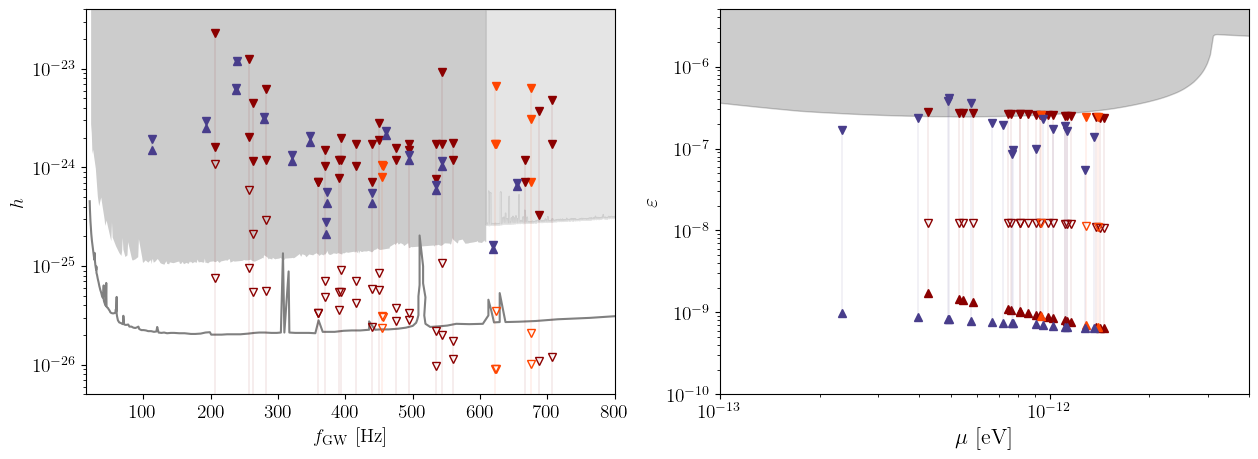

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s = 16
line_w = 0.1
mark_s = 6
min_h_list, max_h_list = [], []

min_y, max_y = 5e-27, 4e-23

ax[0].fill_between(ligo_h2[:, 0][ligo_h2[:, 0]>max(ligo_h[:, 0])], ligo_h2[:, 1][ligo_h2[:, 0]>max(ligo_h[:, 0])], max_y, alpha=0.1, color='k')
ax[0].fill_between(ligo_h[:, 0], ligo_h[:, 1], max_y, alpha=0.2, color='k', linewidth=0)
ax[0].plot(ligo_h_prj[:, 0], ligo_h_prj[:, 1], 'gray')

for i, p_index in enumerate(triplet_ind):
    f0 = 2*df_pulsar_all_sub.iloc[p_index]['F0']
    if i%3==0:
        strain_1 = np.concatenate([strain_list_tr_1[i], strain_list_tr_1[i+1], strain_list_tr_1[i+2]])
        strain = np.concatenate([strain_list_tr[i], strain_list_tr[i+1], strain_list_tr[i+2]])
        ax[0].axvline(f0, 0, (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='solid')
        #ax[0].axvline(f0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='dashed')
        #ax[0].axvline(f0, 0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=0.8, linestyle='solid')
    #ax[0].axvline(f0, (np.log10(min(strain_list_tr[i]))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(strain_list_tr[i]))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[0], linewidth=0.8)
    ax[0].plot(f0, max(strain_list_tr[i]), 'v', c=colorlist[2], markersize=mark_s)
    ax[0].plot(f0, max(strain_list_tr_1[i]), 'v', c=colorlist[2], fillstyle='none', markersize=mark_s)
    #ax[0].plot(f0, max(strain_list_tr_1[i]), 'v', c=colorlist[2], markersize=3)
    
count_pair = 0     
for i, p_index in enumerate(pair_ind):
    f0 = 2*df_pulsar_all_sub.iloc[p_index]['F0']
    strain = strain_list_pr[i][~np.isnan(strain_list_pr[i])]
    strain_1 = strain_list_pr_1[i][~np.isnan(strain_list_pr_1[i])]
    if len(strain)>1:
        count_pair = count_pair+1
        good_doublet.append(p_index)
        good_doublet_i.append(i)
        
        if ((df_pulsar_all_sub.iloc[p_index]['F1'] > 0) & (~isinstance(df_pulsar_all_sub.iloc[p_index]['BINARY'], str))):
            print(df_pulsar_all_sub.iloc[p_index]['NAME'], df_pulsar_all_sub.iloc[p_index]['F0'])
            #ax[0].plot(f0, max(strain), 'o', c=colorlist[0], fillstyle='none', markersize=9, alpha=1)        
        #    strain = np.concatenate([strain_list_pr[i][~np.isnan(strain_list_pr[i])], strain_list_pr[i+1][~np.isnan(strain_list_pr[i])]])
        #    ax[0].axvline(f0, 0, (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=1, linestyle='solid')
        #else:
        ax[0].plot(f0, max(strain), 'v', c=colorlist[1], markersize=mark_s, alpha=1)
        ax[0].plot(f0, max(strain_1), 'v', c=colorlist[1], fillstyle='none', markersize=mark_s, alpha=1)

    if i%2==0:
        strain = np.concatenate([strain_list_pr[i][~np.isnan(strain_list_pr[i])], strain_list_pr[i+1][~np.isnan(strain_list_pr[i])]])
        strain_1 = np.concatenate([strain_list_pr_1[i][~np.isnan(strain_list_pr_1[i])], strain_list_pr_1[i+1][~np.isnan(strain_list_pr_1[i])]])
        if len(strain)>1:
            1
            ax[0].axvline(f0, 0, (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='solid')
            #ax[0].axvline(f0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='dashed')
            #ax[0].axvline(f0, 0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w)



for pul_i in range(len(df_pulsar)):
    selct_pul = ((df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0) )
    #print(pul_i, len(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]>0))
    if len(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]>0):        
        min_h, max_h = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul])
        #list_max[pul_i] = max_h
        min_h_list.append(min_h)
        max_h_list.append(max_h)
        #ax[0].plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=2, c=colorlist[0], alpha=1)
        ax[0].plot(2*df_pulsar.iloc[pul_i]['F0'], min_h, '^', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[0].plot(2*df_pulsar.iloc[pul_i]['F0'], max_h, 'v', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[0].plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=line_w, c=colorlist[0], alpha=1)


ax[0].set_yscale('log');
ax[0].set_xlim(15, 800); ax[0].set_ylim(min_y, max_y)
ax[0].set_xlabel(r'$f_{\rm{GW}}\ [\rm{Hz}]$')
ax[0].set_ylabel(r'$h$');


ax[1].fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)    

min_y, max_y = 1e-10,5e-6
line_w = 0.1

for i, p_index in enumerate(pair_ind):
    if i%2==0:
        e_min = eps_min_pr[i][~np.isnan(eps_min_pr[i])]
        e_min_lum = eps_min_lum_pr[i][~np.isnan(eps_min_lum_pr[i])]
        e_max = eps_max_pr[i][~np.isnan(eps_max_pr[i])]
        e_max_1 = eps_max_pr_1[i][~np.isnan(eps_max_pr_1[i])]

        if len(e_min)>1:
            ax[1].plot(mu_list_pr[i]/eV, min(e_min), '^', c=colorlist[1], markersize=mark_s, alpha=1)
            #ax[1].plot(mu_list_pr[i]/eV, min(e_min_lum), '^', c=colorlist[1], markersize=3, alpha=1)
            ax[1].plot(mu_list_pr[i]/eV, max(e_max), 'v', c=colorlist[1], markersize=mark_s, alpha=1)
            ax[1].plot(mu_list_pr[i]/eV, max(e_max_1), 'v', c=colorlist[1], fillstyle='none', markersize=mark_s, alpha=1)
            ax[1].axvline(mu_list_pr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w)
            #ax[1].axvline(mu_list_pr[i]/eV, (np.log10(max(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='dashed')
            #ax[1].axvline(mu_list_pr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w)
            #ax[1].axvline(mu_list_pr[i]/eV, (np.log10(min(e_min_lum))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='dotted')

for i, p_index in enumerate(triplet_ind):
    if i%3==0:
        e_min = eps_min_tr[i][~np.isnan(eps_min_tr[i])]
        e_min_lum = eps_min_lum_tr[i][~np.isnan(eps_min_lum_tr[i])]
        e_max = eps_max_tr[i][~np.isnan(eps_max_tr[i])]
        e_max_1 = eps_max_tr_1[i][~np.isnan(eps_max_tr_1[i])]

        if len(e_min)>1:
            ax[1].plot(mu_list_tr[i]/eV, min(e_min), '^', c=colorlist[2], markersize=mark_s, alpha=1)
            #ax[1].plot(mu_list_tr[i]/eV, min(e_min_lum), '^', c=colorlist[2], markersize=mark_s, alpha=1)
            ax[1].plot(mu_list_tr[i]/eV, max(e_max), 'v', c=colorlist[2], markersize=mark_s, alpha=1)
            ax[1].plot(mu_list_tr[i]/eV, max(e_max_1), 'v', c=colorlist[2], fillstyle='none', markersize=mark_s, alpha=1)
            ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w)
            #ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='dashed')
            #ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w)
            #ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_min_lum))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='dotted')

count_pul=0
for pul_i in range(len(df_pulsar)):
    selct_pul = ((df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0) )

    if len(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]>0):
        good_fdot.append(pul_i)
        count_pul=count_pul+1
        min_e, max_e = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['eps_min'][selct_pul]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['eps_max'][selct_pul])

        ax[1].plot(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['mu'][selct_pul], df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['eps_Rlum14'][selct_pul] , '.', c=colorlist[0], markersize=mark_s, alpha=1)
        
        ax[1].plot(df_res.iloc[(pul_i)*alpha_points]['mu'], min_e, '^', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[1].plot(df_res.iloc[(pul_i)*alpha_points]['mu'], max_e, 'v', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[1].plot((df_res.iloc[(pul_i)*alpha_points]['mu'],df_res.iloc[(pul_i)*alpha_points]['mu']),(min_e, max_e), linewidth=line_w, c=colorlist[0], alpha=1)

ax[1].set_xscale('log');  
ax[1].set_yscale('log');
ax[1].set_xlim(1e-13, 4e-12); ax[1].set_ylim(min_y, max_y);

ax[1].set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s)
ax[1].set_ylabel(r'$\varepsilon$', fontsize=font_s);

#fig.savefig('plots/pulsars.pdf', bbox_inches="tight")

## Save the results

In [131]:
df_pulsar_triplets = (df_pulsar_all_sub.iloc[triplet_ind]).reset_index(drop=True)
df_pulsar_triplets['F_GW'] = df_pulsar_triplets['F0']*2
df_pulsar_triplets['h_max'] = np.max(strain_list_tr, axis=1)
df_pulsar_triplets.sort_values(by=['F_GW']).reset_index()

,index,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,...,S1400,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE,F_GW,h_max
0,0,J1342+2822F,13:42:11.6,+28:22:38,NaN,NaN,0.004400,NaN,227.272727,NaN,...,NaN,NaN,NaN,10.200,25.000,NaN,NaN,NaN,454.545454,8.009058e-25
1,1,J1803-3002B,18:03:34.0,-30:02:02,NaN,NaN,0.004397,NaN,227.427792,NaN,...,NaN,NaN,NaN,7.700,5.802,NaN,NaN,NaN,454.855584,1.060940e-24
2,2,J1823-3021E,18:23:38.9,-30:22:22.3,NaN,NaN,0.004394,NaN,227.583068,NaN,...,NaN,NaN,NaN,7.900,3.372,NaN,NaN,NaN,455.166136,1.034082e-24
3,3,B0021-72H,00:24:06.7,-72:04:06.8,5.1,-2.8,0.003210,-1.830000e-21,311.493418,1.775000e-16,...,NaN,NaN,DD,4.690,2.541,NaN,NaN,NaN,622.986836,1.741826e-24
4,4,J1628-3205,16:28:07.0,-32:05:48.9,NaN,NaN,0.003210,NaN,311.526480,NaN,...,NaN,NaN,BT,1.225,1.225,NaN,NaN,NaN,623.052960,6.668702e-24
5,5,J1930+1403g,19:30:18,+14:03,NaN,NaN,0.003210,NaN,311.526480,NaN,...,0.09,NaN,NaN,4.740,4.740,NaN,2.11,NaN,623.052960,1.723451e-24
6,6,J1624-39,16:24:25,-39:51:00,NaN,NaN,0.002960,NaN,337.837838,NaN,...,NaN,NaN,NaN,2.629,2.629,NaN,NaN,NaN,675.675676,3.107325e-24
7,7,J2045-68,20:45:17,-68:36:20,NaN,NaN,0.002960,NaN,337.837838,NaN,...,NaN,NaN,NaN,1.273,1.273,NaN,NaN,NaN,675.675676,6.417248e-24
8,8,J0514-4002L,05:14:06.8,-40:02:48.0,NaN,NaN,0.002959,NaN,337.974855,NaN,...,NaN,NaN,BT,11.440,25.000,NaN,NaN,NaN,675.949710,7.140887e-25


In [132]:
df_pulsar_doublets = (df_pulsar_all_sub.iloc[good_doublet]).reset_index(drop=True)
df_pulsar_doublets['F_GW'] = df_pulsar_doublets['F0']*2
df_pulsar_doublets['h_max'] = np.max(strain_list_pr[good_doublet_i], axis=1)
df_pulsar_doublets.sort_values(by=['F_GW']).reset_index()

,index,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,...,S1400,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE,F_GW,h_max
0,20,J1748-3009,17:48:23.7,-30:09:11.2,NaN,NaN,0.009684,-3.580000e-20,103.263527,3.817000e-16,...,1.40,NaN,BT,5.053,5.053,NaN,35.7000,NaN,206.527054,1.613490e-24
1,21,J0921-5202,09:21,-52:02,NaN,NaN,0.009680,NaN,103.305785,NaN,...,0.19,NaN,NaN,0.355,0.355,NaN,0.0238,NaN,206.611570,2.296619e-23
2,4,J1122-3546,11:22,-35:46,NaN,NaN,0.007800,NaN,128.205128,NaN,...,NaN,NaN,NaN,0.656,0.656,NaN,NaN,NaN,256.410256,1.244706e-23
3,5,J1546-5925,15:46,-59:25,NaN,NaN,0.007800,NaN,128.205128,NaN,...,0.27,NaN,NaN,4.004,4.004,NaN,4.3100,NaN,256.410256,2.039279e-24
4,32,J2129-0429,21:29:45.0,-04:29:05.5,12.34,10.19,0.007620,NaN,131.233596,NaN,...,NaN,NaN,ELL1,1.830,1.385,1.670,NaN,NaN,262.467192,4.462355e-24
5,33,J1701-3006C,17:01:12.8,-30:06:59.4,NaN,NaN,0.007613,-6.410000e-20,131.356873,1.107000e-15,...,0.30,0.72,BT,7.050,4.834,NaN,14.9000,NaN,262.713746,1.158318e-24
6,36,J1551-0658,15:51:07.2,-06:58:06.5,NaN,NaN,0.007090,NaN,141.043724,NaN,...,NaN,NaN,NaN,1.325,1.325,0.878,NaN,NaN,282.087448,6.164581e-24
7,37,J1748-2446T,17:48:04.8,-24:46:45,NaN,NaN,0.007085,NaN,141.145053,NaN,...,NaN,0.02,NaN,6.900,4.390,NaN,NaN,NaN,282.290106,1.183780e-24
8,12,J0514-4002N,05:14:06.7,-40:02:47,NaN,NaN,0.005568,NaN,179.600927,NaN,...,NaN,NaN,NaN,11.440,25.000,NaN,NaN,NaN,359.201854,7.139653e-25
9,13,J0514-4002C,05:14:06.6,-40:02:49.4,NaN,NaN,0.005565,NaN,179.700978,NaN,...,NaN,NaN,NaN,11.440,25.000,NaN,NaN,NaN,359.401956,7.139642e-25


In [127]:
df_pulsar_fdot = (df_pulsar.iloc[good_fdot]).reset_index(drop=True)
df_pulsar_fdot['F_GW'] = df_pulsar_fdot['F0']*2
df_pulsar_fdot['h_max'] = max_h_list
df_pulsar_fdot['h_min'] = min_h_list
df_pulsar_fdot.sort_values(by=['F_GW']).reset_index()

,index,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,...,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE,F_GW,h_max,h_min
0,0,J1757-2745,17:57:54.7,-27:45:40.1,-11.40,54.00,0.017687,-1.300000e-20,56.538013,4.170000e-17,...,NaN,NaN,8.208,8.208,NaN,4.72,NaN,113.076026,1.959393e-24,1.514261e-24
1,1,B1639+36A,16:41:40.8,+36:27:14.9,NaN,NaN,0.010378,-7.270000e-20,96.362235,6.750000e-16,...,NaN,NaN,7.100,6.736,151.0,7.06,NaN,192.724470,2.921555e-24,2.502112e-24
2,2,J1748-2446C,17:48:04.5,-24:46:36,NaN,NaN,0.008436,-6.060000e-19,118.538253,8.515000e-15,...,NaN,NaN,6.900,4.385,NaN,NaN,NaN,237.076506,6.310973e-24,6.100835e-24
3,3,J1910-5959B,19:10:52.0,-59:59:00.8,NaN,NaN,0.008358,-7.900000e-19,119.648733,1.132000e-14,...,NaN,NaN,4.000,1.631,NaN,0.80,NaN,239.297466,1.192882e-23,1.190303e-23
4,4,J1801-0857A,18:01:50.6,-08:57:31.8,NaN,NaN,0.007176,-5.100000e-19,139.360885,9.912000e-15,...,0.02,NaN,10.600,6.684,NaN,4.04,NaN,278.721770,3.222905e-24,3.124445e-24
5,5,J1748-2021C,17:48:51.1,-20:21:53.8,NaN,NaN,0.006227,-5.980000e-20,160.592710,1.543000e-15,...,0.04,NaN,8.500,9.318,NaN,NaN,NaN,321.185420,1.338338e-24,1.165716e-24
6,6,B0021-72C,00:23:50.3,-72:04:31.5,5.20,-3.10,0.005757,-4.990000e-20,173.708219,1.504000e-15,...,0.23,NaN,4.690,2.594,33.7,11.40,NaN,347.416438,2.068884e-24,1.790000e-24
7,7,J1911+0101B,19:11:12.5,+01:01:50.4,NaN,NaN,0.005384,-2.000000e-21,185.724277,6.899000e-17,...,NaN,NaN,7.400,8.681,NaN,NaN,NaN,371.448554,2.800306e-25,2.134588e-25
8,8,B0021-72D,00:24:13.8,-72:04:43.8,4.24,-2.24,0.005358,-3.420000e-21,186.651670,1.192000e-16,...,0.20,NaN,4.690,2.631,20.9,7.70,NaN,373.303340,5.606076e-25,4.381236e-25
9,9,J0024-7204Z,00:24:06.0,-72:05:01.4,4.00,1.00,0.004554,-4.540000e-21,219.565606,2.190000e-16,...,NaN,NaN,4.690,2.559,NaN,NaN,NaN,439.131212,5.449724e-25,4.342988e-25


In [128]:
#df_pulsar_triplets.to_csv('pulsar_data/pulsar_triplets.csv')
#len(df_pulsar_triplets)

9

In [129]:
#df_pulsar_doublets.to_csv('pulsar_data/pulsar_doublets.csv')
#len(df_pulsar_doublets)

38

In [130]:
#df_pulsar_fdot.to_csv('pulsar_data/pulsar_fdot.csv')
#len(df_pulsar_fdot)

16